In [ ]:
import pandas as pd
from pandas import read_excel
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.models import model_from_json
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.utils import class_weight
from google.colab import drive

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
import pickle
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve 

In [ ]:
drive.mount("/content/gdrive")

tf.test.gpu_device_name()

Mounted at /content/gdrive


'/device:GPU:0'

In [ ]:
location = "/content/gdrive/My Drive/Colab Notebooks/MultiModal_PD/"

# **Extra Preprocessing**

---



In [ ]:
df = pd.read_csv(location + "biospecimen_masterDB.csv", sep=",")
df.head()

,PATNO,ABETA42,A_SYN,P_TAU,T_TAU,URATE,STATUS
0,3915.0,1119.375,1719.650,13.1200,158.350,237.000000,1
1,3914.0,614.150,1584.650,14.0825,174.325,270.285714,1
2,3838.0,746.900,1256.775,10.9825,137.050,234.571429,1
3,3819.0,612.020,1136.380,8.4880,109.100,231.875000,1
4,3900.0,511.280,1263.540,11.3980,145.260,400.666667,1


In [ ]:
df = df.drop(columns = ["PATNO"], axis = 1)
df.head()

,ABETA42,A_SYN,P_TAU,T_TAU,URATE,STATUS
0,1119.375,1719.650,13.1200,158.350,237.000000,1
1,614.150,1584.650,14.0825,174.325,270.285714,1
2,746.900,1256.775,10.9825,137.050,234.571429,1
3,612.020,1136.380,8.4880,109.100,231.875000,1
4,511.280,1263.540,11.3980,145.260,400.666667,1


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df["P_TAU/T_TAU"] = df["P_TAU"]/df["T_TAU"]
df["P_TAU/ABETA42"] = df["P_TAU"]/df["ABETA42"]
df["T_TAU/ABETA42"] = df["T_TAU"]/df["ABETA42"]
df["ABETA42/A_SYN"] = df["ABETA42"]/df["A_SYN"]
df["P_TAU/A_SYN"] = df["P_TAU"]/df["A_SYN"]
df["T_TAU/A_SYN"] = df["T_TAU"]/df["A_SYN"]
df.head()

,ABETA42,A_SYN,P_TAU,T_TAU,URATE,STATUS,P_TAU/T_TAU,P_TAU/ABETA42,T_TAU/ABETA42,ABETA42/A_SYN,P_TAU/A_SYN,T_TAU/A_SYN
0,651.940,1137.98,10.015,121.018,338.250000,1,0.082756,0.015362,0.185628,0.572892,0.008801,0.106345
1,1014.900,1220.62,11.824,142.160,274.600000,0,0.083174,0.011650,0.140073,0.831463,0.009687,0.116465
2,1379.000,2193.90,16.360,206.100,258.428571,1,0.079379,0.011864,0.149456,0.628561,0.007457,0.093942
3,1119.375,1719.65,13.120,158.350,237.000000,1,0.082854,0.011721,0.141463,0.650932,0.007629,0.092083
4,765.100,870.90,9.450,112.520,205.333333,1,0.083985,0.012351,0.147066,0.878516,0.010851,0.129200


In [ ]:
cols = ['ABETA42', 'A_SYN', 'P_TAU', 'T_TAU', 'URATE', "P_TAU/T_TAU",	"P_TAU/ABETA42", "T_TAU/ABETA42",	"ABETA42/A_SYN", "P_TAU/A_SYN", "T_TAU/A_SYN",'STATUS']
df = df[cols]
df.head()

,ABETA42,A_SYN,P_TAU,T_TAU,URATE,P_TAU/T_TAU,P_TAU/ABETA42,T_TAU/ABETA42,ABETA42/A_SYN,P_TAU/A_SYN,T_TAU/A_SYN,STATUS
0,651.940,1137.98,10.015,121.018,338.250000,0.082756,0.015362,0.185628,0.572892,0.008801,0.106345,1
1,1014.900,1220.62,11.824,142.160,274.600000,0.083174,0.011650,0.140073,0.831463,0.009687,0.116465,0
2,1379.000,2193.90,16.360,206.100,258.428571,0.079379,0.011864,0.149456,0.628561,0.007457,0.093942,1
3,1119.375,1719.65,13.120,158.350,237.000000,0.082854,0.011721,0.141463,0.650932,0.007629,0.092083,1
4,765.100,870.90,9.450,112.520,205.333333,0.083985,0.012351,0.147066,0.878516,0.010851,0.129200,1


# **XGBoost Feature Selection**

---

In [ ]:
print(len(df))

input_columns=len(df.columns)-1
output_columns=1

X = df.iloc[:, 0:input_columns]
y = df.iloc[:, -1]

641


11
A_SYN            0.128199
P_TAU/T_TAU      0.125018
P_TAU/ABETA42    0.100478
T_TAU/ABETA42    0.088594
URATE            0.088161
T_TAU/A_SYN      0.085861
T_TAU            0.085131
P_TAU            0.081397
ABETA42/A_SYN    0.077111
P_TAU/A_SYN      0.074568
ABETA42          0.065480
dtype: float32


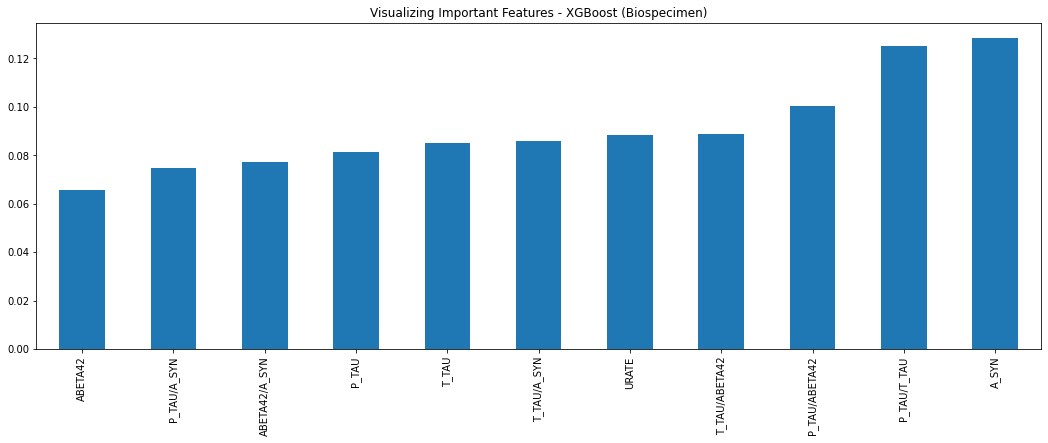

In [ ]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X, y)

feature_imp = pd.Series(xgb_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(len(feature_imp[feature_imp>0]))
print(feature_imp[feature_imp>0])

feature_imp.sort_values().tail(30).plot(kind = 'bar', figsize = (18,6))
plt.title("Visualizing Important Features - XGBoost (Biospecimen)")
plt.show()

feaSel_xgb = list(feature_imp[feature_imp>0].index)

In [ ]:
file = location + "feaSel_xgb_Biospec.txt"
with open(file, 'w') as file:
        for row in feaSel_xgb:
            s = "".join(map(str, row))
            file.write(s+'\n')

# **ML Models**

---



In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
print(len(df))

input_columns = 5
output_columns = 1

641


In [ ]:
train_length = int(0.8*len(df))
test_length = int(0.2*len(df))+1
print(train_length, test_length)

512 129


In [ ]:
# dataset = df.values
X = df.iloc[:train_length,0:input_columns]
y = df.iloc[:train_length, -1]

X_test = df.iloc[train_length: (train_length + test_length), 0:input_columns]
y_test = df.iloc[train_length: (train_length + test_length), -1]

Train Data distribtuion:
PD    362
HC    150
Name: STATUS, dtype: int64


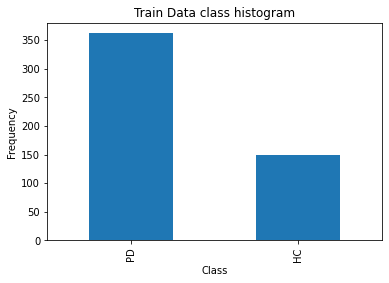

In [ ]:
# Train data distribution
count_classes = y.replace({0:"HC", 1:"PD"}).value_counts()
print("Train Data distribtuion:")
print(count_classes)
plt.title("Train Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

Test Data distribtuion:
PD    94
HC    35
Name: STATUS, dtype: int64


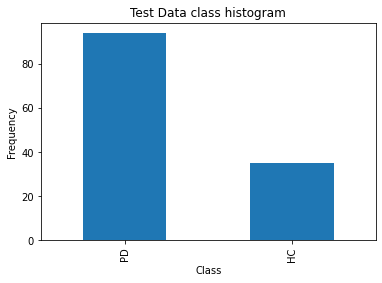

In [ ]:
# Test data distribution
count_classes = y_test.replace({0:"HC", 1:"PD"}).value_counts()
print("Test Data distribtuion:")
print(count_classes)
plt.title("Test Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

In [ ]:
scalarX = MinMaxScaler() # Normalising
scalarX.fit(X)

X = scalarX.transform(X)
X_test = scalarX.transform(X_test)

## **Random Forest**

---

In [ ]:
clf = RandomForestClassifier()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

#Setting the range for class weights
weights = np.linspace(0.6,0.99,50)


# specify parameters and distributions to sample from
hp = {
    'bootstrap': [True, False],
      'criterion': ['gini', 'entropy'],
      # 'n_estimators': [10, 25], 
      # 'max_features': [5, 10], 
      # 'max_depth': [10, 50, None], 
      'max_depth': np.arange(1, 5, 1),
      'max_features': ['auto', 'sqrt', 'log2', 1, 2, 3, 4, 5],
      # 'min_samples_leaf': [0, 1, 2, 3, 4, 5],
      # 'min_samples_split': [1, 2, 5, 10],
      'n_estimators': np.arange(10, 200, 10),
      'warm_start': [True, False],
      'class_weight': [{0:x, 1:1.0-x} for x in weights]
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 250
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search,
                                    cv=StratifiedKFold(),
                                    verbose = 5,
                                    scoring='roc_auc',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'biospec_RF' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:  2.8min finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight={0: 0.6557142857142857,
                                     1: 0.3442857142857143},
                       criterion='gini', max_depth=3, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'bootstrap': False,
 'class_weight': {0: 0.6557142857142857, 1: 0.3442857142857143},
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 4,
 'n_estimators': 180,
 'warm_start': False}

Saving model



AUC-ROC =  0.6528875379939209
AUC-PR =  0.8298564005912351
F1 score =  0.7914438502673796
Precision =  0.7956989247311828
Recall =  0.7872340425531915
              precision    recall  f1-score   support

           0       0.44      0.46      0.45        35
           1       0.80      0.79      0.79        94

    accuracy                           0.70       129
   macro avg       0.62      0.62      0.62       129
weighted avg       0.70      0.70      0.70       129



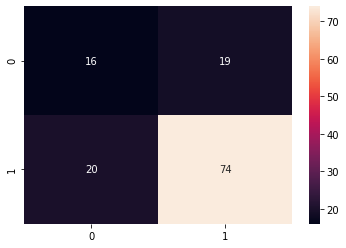

In [ ]:
# load the model from disk
filename = location + 'biospec_RF' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_rf = clf


y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

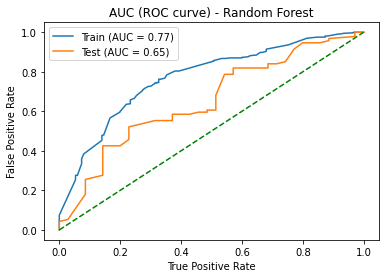

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

for i in range(2):
    plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Random Forest")
plt.show()

## **Gaussian Naive Bayes**

---

In [ ]:
clf = GaussianNB()
 
# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())
 
# specify parameters and distributions to sample from
hp = {'var_smoothing': np.logspace(0,-9, num=50)}
# pprint(hp)
 
# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 200
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search, 
                                    cv=StratifiedKFold(),
                                    verbose = 5, 
                                    scoring='roc_auc',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)
 
#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)
 
pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)
 
print("\nSaving model\n")
 
clf = random_search.best_estimator_
 
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)
 
# save the model to disk
filename = location + 'biospec_GNB' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 50 is smaller than n_iter=200. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.2s


GaussianNB(priors=None, var_smoothing=1.0)
{'var_smoothing': 1.0}

Saving model



[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished


AUC-ROC =  0.739209726443769
AUC-PR =  0.8766076592512928
F1 score =  0.8611111111111112
Precision =  0.7622950819672131
Recall =  0.9893617021276596
              precision    recall  f1-score   support

           0       0.86      0.17      0.29        35
           1       0.76      0.99      0.86        94

    accuracy                           0.77       129
   macro avg       0.81      0.58      0.57       129
weighted avg       0.79      0.77      0.70       129



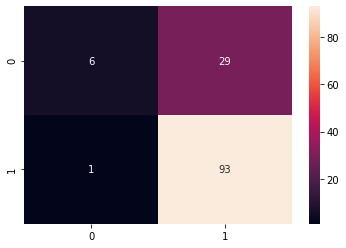

In [ ]:
# load the model from disk
filename = location + 'biospec_GNB' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_gnb = clf

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

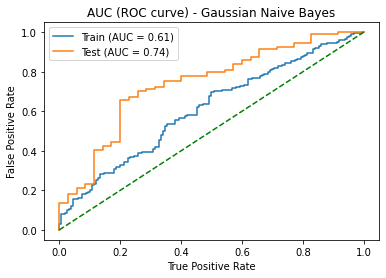

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

for i in range(2):
    plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Gaussian Naive Bayes")
plt.show()

## **SVM**

---

In [ ]:
clf = SVC()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'C': [0.0001, 0.001, 0.01, 0.1, 0, 1, 10, 25, 50, 75, 100],
      'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
      'gamma': ['scale', 'auto'],
      'shrinking': [True, False],
      'class_weight': [{0:x, 1:1.0-x} for x in weights],
      # 'decision_function_shape': ['ovo', 'ovr']
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 200
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search, 
                                    cv=StratifiedKFold(),
                                    verbose = 5, 
                                    scoring='balanced_accuracy',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'biospec_SVM_1' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 751 tasks      | elapsed:  1.1min


SVC(C=100, break_ties=False, cache_size=200,
    class_weight={0: 0.7114285714285714, 1: 0.2885714285714286}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'C': 100,
 'class_weight': {0: 0.7114285714285714, 1: 0.2885714285714286},
 'gamma': 'auto',
 'kernel': 'rbf',
 'shrinking': True}

Saving model



[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.8min finished


AUC-ROC =  0.646048632218845
AUC-PR =  0.865719989133704
F1 score =  0.7037037037037038
Precision =  0.8382352941176471
Recall =  0.6063829787234043
              precision    recall  f1-score   support

           0       0.39      0.69      0.50        35
           1       0.84      0.61      0.70        94

    accuracy                           0.63       129
   macro avg       0.62      0.65      0.60       129
weighted avg       0.72      0.63      0.65       129



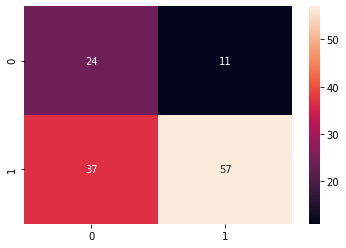

In [ ]:
# load the model from disk
filename = location + 'biospec_SVM_1' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_svm = clf

y_pred = clf.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_pred)
print("AUC-ROC = ", auc(fpr,tpr))
prec, rec, thresholds = precision_recall_curve(y_test, y_pred)
print("AUC-PR = ", auc(rec, prec))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

SVC(C=100, break_ties=False, cache_size=200,
    class_weight={0: 0.7114285714285714, 1: 0.2885714285714286}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


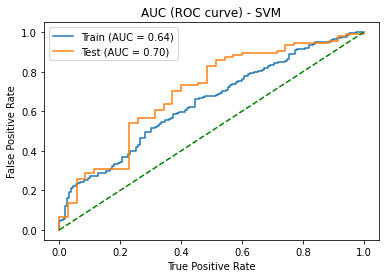

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf)

for i in range(2):
  plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - SVM")
plt.show()

## **Logistic Regression**

---

In [ ]:
clf = LogisticRegression()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'C': [0.0001, 0.001, 0.01, 0.1, 0, 1, 10, 25, 50, 75, 100],
      'penalty': ['l1', 'l2', 'elasticnet'],
      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
      'class_weight': [{0:x, 1:1.0-x} for x in weights],
      'multi_class': ['multinomial', 'ovr', 'auto'],
      'warm_start': [True, False],
      'l1_ratio': np.arange(0, 1.1, 0.1),
      'random_state': [81]
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 1500
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search, 
                                    cv=StratifiedKFold(),
                                    verbose = 5, 
                                    scoring='balanced_accuracy',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'biospec_logReg_1' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1350 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 4230 tasks      | elapsed:   14.5s


LogisticRegression(C=50,
                   class_weight={0: 0.703469387755102, 1: 0.29653061224489796},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=0.2, max_iter=100, multi_class='ovr', n_jobs=None,
                   penalty='l1', random_state=81, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=False)
{'C': 50,
 'class_weight': {0: 0.703469387755102, 1: 0.29653061224489796},
 'l1_ratio': 0.2,
 'multi_class': 'ovr',
 'penalty': 'l1',
 'random_state': 81,
 'solver': 'liblinear',
 'warm_start': False}

Saving model



[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   24.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


AUC-ROC =  0.6711246200607902
AUC-PR =  0.8282634688497433
F1 score =  0.7065868263473053
Precision =  0.8082191780821918
Recall =  0.6276595744680851
              precision    recall  f1-score   support

           0       0.38      0.60      0.46        35
           1       0.81      0.63      0.71        94

    accuracy                           0.62       129
   macro avg       0.59      0.61      0.58       129
weighted avg       0.69      0.62      0.64       129



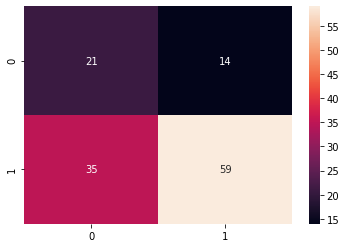

In [ ]:
# load the model from disk
filename = location + 'biospec_logReg_1' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_logReg = clf

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

LogisticRegression(C=50,
                   class_weight={0: 0.703469387755102, 1: 0.29653061224489796},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=0.2, max_iter=100, multi_class='ovr', n_jobs=None,
                   penalty='l1', random_state=81, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=False)


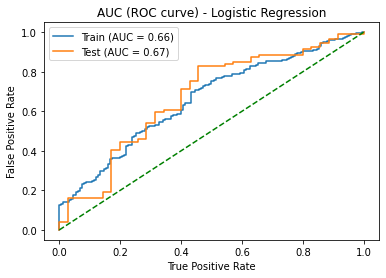

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf)

for i in range(2):
  plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Logistic Regression")
plt.show()

## **Stochastic Gradient Descent**

---

In [ ]:
clf = SGDClassifier()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'alpha': [0.0001, 0.001, 0.01, 0.1,0.15,0.2,0.5,0.8,1],
      'l1_ratio': [0,0.1,0.15,0.18,0.2,0.3],
      'loss': ['log'],
      'class_weight': [{0:x, 1:1.0-x} for x in weights],
      'random_state': [81],
      'tol': [None]
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 500
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search, 
                                    cv=StratifiedKFold(),
                                    verbose = 5, 
                                    scoring='balanced_accuracy',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'biospec_SGD_1' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 1284 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2292 tasks      | elapsed:  1.5min


SGDClassifier(alpha=0.0001, average=False,
              class_weight={0: 0.7193877551020408, 1: 0.2806122448979592},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.1, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=81, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)
{'alpha': 0.0001,
 'class_weight': {0: 0.7193877551020408, 1: 0.2806122448979592},
 'l1_ratio': 0.1,
 'loss': 'log',
 'random_state': 81,
 'tol': None}

Saving model



[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  1.7min finished


AUC-ROC =  0.6872340425531914
AUC-PR =  0.8436504838485799
F1 score =  0.6987951807228916
Precision =  0.8055555555555556
Recall =  0.6170212765957447
              precision    recall  f1-score   support

           0       0.37      0.60      0.46        35
           1       0.81      0.62      0.70        94

    accuracy                           0.61       129
   macro avg       0.59      0.61      0.58       129
weighted avg       0.69      0.61      0.63       129



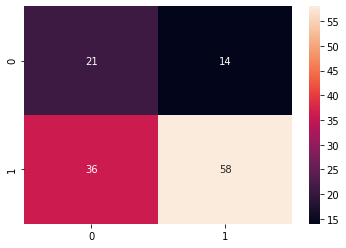

In [ ]:
# load the model from disk
filename = location + 'biospec_SGD_1' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_SGD = clf

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

SGDClassifier(alpha=0.0001, average=False,
              class_weight={0: 0.7193877551020408, 1: 0.2806122448979592},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.1, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=81, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)


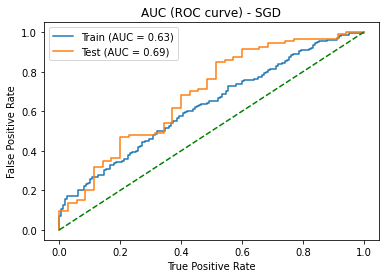

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf)

for i in range(2):
  plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - SGD")
plt.show()

## **ROC Curve**

---

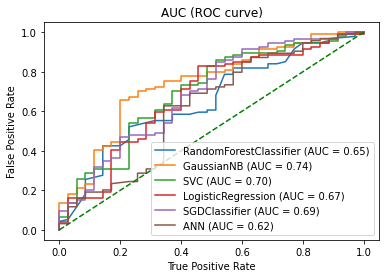

In [ ]:
ax = plt.gca()
classifiers = [clf_rf, clf_gnb, clf_svm, clf_logReg, clf_SGD]

for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)
plt.plot(fpr_test, tpr_test, label='ANN (AUC = {:.2f})'.format(auc_test))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve)")
plt.show()

In [ ]:
# def remove_imbalance(X, y, flag):

#   y = y.reshape(len(y),1)

#   print("Before Sampling, counts of label '1': {}".format(sum(y == 1)))
#   print("Before Sampling, counts of label '0': {} \n".format(sum(y == 0)))

#   if(flag == 1):
#     smt = SMOTE()
#     X, y = smt.fit_resample(X, y)
  
#   if(flag == 2):
#     ada = ADASYN()
#     X, y = ada.fit_resample(X, y)

#   if(flag == 3):
#     smtom = SMOTETomek()
#     X,y = smtom.fit_resample(X, y)

#   if(flag == 4):
#     smenn = SMOTEENN()
#     X, y = smenn.fit_resample(X, y)

#   y = y.reshape(len(y), 1)

#   print("After Sampling, counts of label '1': {}".format(sum(y == 1)))
#   print("After Sampling, counts of label '0': {} \n".format(sum(y == 0)))

#   return (X, y)  

In [ ]:
# (X, y) = remove_imbalance(X, y, int(2))

# **ANN**

---



#### **Defining Train_data, Val_data and Test data**

---



In [ ]:
dataset = df.values

train_length = int(0.6*len(df))
val_length = int(0.2*len(df))
test_length = int(0.2*len(df))+1

X = dataset[:train_length,0:input_columns]
y = dataset[:train_length, -1].reshape(train_length, 1)

X_valid = dataset[train_length: (train_length + val_length), 0:input_columns]
y_valid = dataset[train_length: (train_length + val_length), -1].reshape(val_length, 1)

X_test = dataset[(train_length + val_length): (train_length + val_length + test_length), 0:input_columns]
y_test = dataset[(train_length + val_length): (train_length + val_length + test_length), -1].reshape(test_length, 1)

# USING CLASS WEIGHTS
class_weights = dict(zip(np.unique(y.flatten()), class_weight.compute_class_weight('balanced', np.unique(y.flatten()), y.flatten())))

scalarX = MinMaxScaler()
scalarX.fit(X)

X = scalarX.transform(X)
X_valid = scalarX.transform(X_valid)
X_test = scalarX.transform(X_test)

print(len(X), len(X_valid), len(X_test))

384 128 129


Train Data distribtuion:
PD    268
HC    116
Name: STATUS, dtype: int64


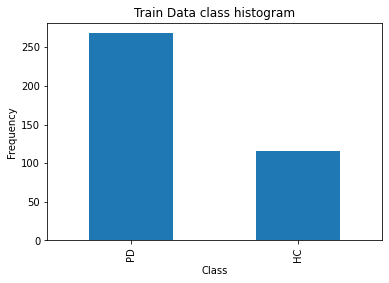

In [ ]:
# Train data distribution
count_classes = df.iloc[:train_length, -1].replace({0:"HC", 1:"PD"}).value_counts()
print("Train Data distribtuion:")
print(count_classes)
plt.title("Train Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

Val Data distribtuion:
PD    94
HC    34
Name: STATUS, dtype: int64


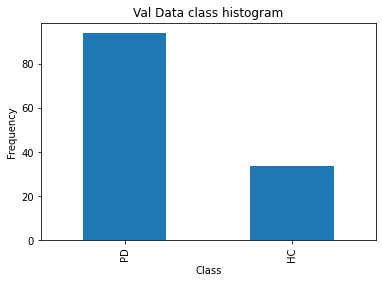

In [ ]:
# Val data distribution
count_classes = df.iloc[train_length: (train_length + val_length), -1].replace({0:"HC", 1:"PD"}).value_counts()
print("Val Data distribtuion:")
print(count_classes)
plt.title("Val Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

Test Data distribtuion:
1    94
0    35
Name: STATUS, dtype: int64


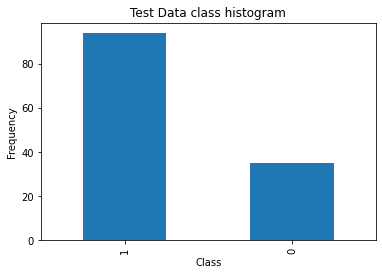

In [ ]:
# Test data distribution
count_classes = df.iloc[(train_length + val_length): (train_length + val_length + test_length), -1].value_counts()
print("Test Data distribtuion:")
print(count_classes)
plt.title("Test Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

# **Training the Model**

---



In [ ]:
model = Sequential()
model.add(Dense(2, input_dim=input_columns, activation='relu'))
model.add(Dense(output_columns, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 3         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 5
num_epoch = 100
output = model.fit(X, y, batch_size = batch_size, epochs=num_epoch, verbose=1,
                   class_weight=class_weights, validation_data=(X_valid, y_valid))

Epoch 1/100
77/77 [==============================] - 1s 4ms/step - loss: 0.7148 - val_loss: 0.8023
Epoch 2/100
77/77 [==============================] - 0s 3ms/step - loss: 0.7016 - val_loss: 0.7751
Epoch 3/100
77/77 [==============================] - 0s 3ms/step - loss: 0.7008 - val_loss: 0.7517
Epoch 4/100
77/77 [==============================] - 0s 3ms/step - loss: 0.6906 - val_loss: 0.7365
Epoch 5/100
77/77 [==============================] - 0s 3ms/step - loss: 0.6795 - val_loss: 0.7235
Epoch 6/100
77/77 [==============================] - 0s 3ms/step - loss: 0.6884 - val_loss: 0.7173
Epoch 7/100
77/77 [==============================] - 0s 2ms/step - loss: 0.6872 - val_loss: 0.7120
Epoch 8/100
77/77 [==============================] - 0s 3ms/step - loss: 0.6927 - val_loss: 0.7113
Epoch 9/100
77/77 [==============================] - 0s 2ms/step - loss: 0.6721 - val_loss: 0.7074
Epoch 10/100
77/77 [==============================] - 0s 3ms/step - loss: 0.6834 - val_loss: 0.7060
Epoch 11/

<Figure size 432x288 with 0 Axes>

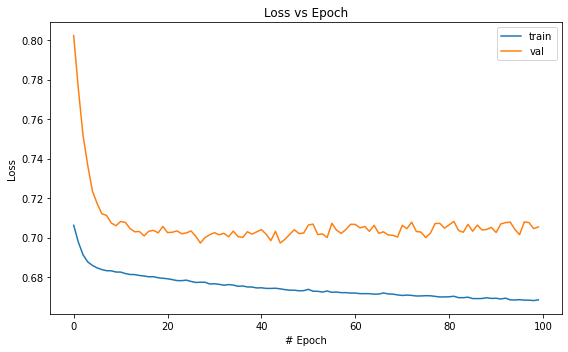

In [ ]:
fig = plt.figure()
plt.figure(figsize=(8,5))
plt.plot(output.history['loss'])
plt.plot(output.history['val_loss'])
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('# Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.tight_layout()

### **Save Model**

In [ ]:
# Saving the model
print("\nSaving model")
# serialize model to JSON
model_json = model.to_json()
with open(location + "biospec_ann.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model as json")
# serialize weights to HDF5
model.save_weights(location + "biospec_ann_wt.h5")
print("Saved model weights")


Saving model
Saved model as json
Saved model weights


### **Load Model**

# **Model Evaluation**

---



Train AUC-ROC = 0.63
Validation AUC-ROC = 0.52
Test AUC-ROC = 0.62


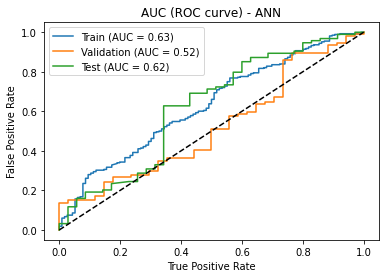

In [ ]:
# model = loaded_model # Loaded model

pred = model.predict(X)
# train_y_pred = np.where(pred > 0.5, 1, 0)
fpr_train, tpr_train, _ = roc_curve(y, pred)
auc_train = auc(fpr_train, tpr_train).round(2)
print("Train AUC-ROC =", str(auc_train))

pred = model.predict(X_valid)
# val_y_pred = np.where(pred > 0.5, 1, 0)
fpr_val, tpr_val, _ = roc_curve(y_valid, pred)
auc_val = auc(fpr_val, tpr_val).round(2)
print("Validation AUC-ROC =", str(auc_val))

pred = model.predict(X_test)
# test_y_pred = np.where(pred > 0.5, 1, 0)
fpr_test, tpr_test, _ = roc_curve(y_test, pred)
auc_test = auc(fpr_test, tpr_test).round(2)
print("Test AUC-ROC =", str(auc_test))

plt.plot(fpr_train, tpr_train, label='Train (AUC = {:.2f})'.format(auc_train))
plt.plot(fpr_val, tpr_val, label='Validation (AUC = {:.2f})'.format(auc_val))
plt.plot(fpr_test, tpr_test, label='Test (AUC = {:.2f})'.format(auc_test))
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - ANN")
plt.show()

In [ ]:
def check_metrics(model, testX, testY):  

  pred = model.predict(testX)
  y_pred = np.where(pred > 0.5, 1, 0)
  print('##############  Confusion Matrix  ##############')
  print()
  np.set_printoptions(threshold=np.inf)
  print(confusion_matrix(testY, y_pred))
  np.set_printoptions(threshold=100)
  print()
  print('##############  Classification Report  ##############')
  print()
  print(classification_report(testY, y_pred))

In [ ]:
check_metrics(model, X_valid, y_valid)

##############  Confusion Matrix  ##############

[[17 17]
 [53 41]]

##############  Classification Report  ##############

              precision    recall  f1-score   support

         0.0       0.24      0.50      0.33        34
         1.0       0.71      0.44      0.54        94

    accuracy                           0.45       128
   macro avg       0.47      0.47      0.43       128
weighted avg       0.58      0.45      0.48       128



In [ ]:
check_metrics(model, X, y)

##############  Confusion Matrix  ##############

[[ 60  56]
 [105 163]]

##############  Classification Report  ##############

              precision    recall  f1-score   support

         0.0       0.36      0.52      0.43       116
         1.0       0.74      0.61      0.67       268

    accuracy                           0.58       384
   macro avg       0.55      0.56      0.55       384
weighted avg       0.63      0.58      0.60       384



In [ ]:
check_metrics(model, X_test, y_test)

##############  Confusion Matrix  ##############

[[20 15]
 [35 59]]

##############  Classification Report  ##############

              precision    recall  f1-score   support

         0.0       0.36      0.57      0.44        35
         1.0       0.80      0.63      0.70        94

    accuracy                           0.61       129
   macro avg       0.58      0.60      0.57       129
weighted avg       0.68      0.61      0.63       129



In [ ]:
index = 2

testing = (X_valid[index, :]).reshape(1,input_columns)
print(testing)
pred = model.predict(testing)
print("PREDICTION BY MODEL:", pred[0])
if (pred > 0.5):
  print("CLASS IS PD")
else:
  print("CLASS IS HC")
print("TRUE VALUE:", y_valid[index])

[[0.34214024 0.27632735 0.07505419 0.14754164 0.13106796]]
PREDICTION BY MODEL: [0.45257032]
CLASS IS HC
TRUE VALUE: [1.]


# **Checking Correlations**

---



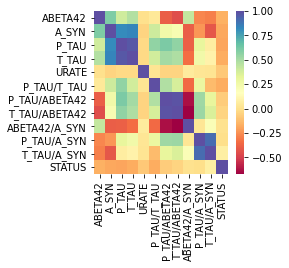

In [ ]:
plt.figure(figsize=(3,3))
cor = df.corr()
sns.heatmap(cor, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
print("IMPORTANT FEATURES")
print()
for i in range(input_columns):
    corr1, _ = spearmanr(X[:,i], y[:, 0])
    corr2, _ = pearsonr(X[:,i], y[:, 0])
    if(abs(corr1) > 0.1 or abs(corr2) > 0.1 ):
        print(df.columns[i]+":\t\t",'Spearmans correlation: %.3f' % abs(corr1), 'Pearsons correlation: %.3f' % abs(corr2) )
print()

print("REDUNDANT FEATURES")
print()
for i in range(input_columns):
    corr1, _ = spearmanr(X[:,i], y[:, 0])
    corr2, _ = pearsonr(X[:,i], y[:, 0])
    if(abs(corr1)< 0.1 or abs(corr2) < 0.1 ):
        print(df.columns[i]+":\t\t",'Spearmans correlation: %.3f' % abs(corr1), 'Pearsons correlation: %.3f' % abs(corr2) )
print()

IMPORTANT FEATURES

ABETA42:		 Spearmans correlation: 0.136 Pearsons correlation: 0.150
A_SYN:		 Spearmans correlation: 0.166 Pearsons correlation: 0.145
P_TAU:		 Spearmans correlation: 0.151 Pearsons correlation: 0.162
T_TAU:		 Spearmans correlation: 0.127 Pearsons correlation: 0.140
P_TAU/T_TAU:		 Spearmans correlation: 0.176 Pearsons correlation: 0.160
T_TAU/ABETA42:		 Spearmans correlation: 0.100 Pearsons correlation: 0.025

REDUNDANT FEATURES

URATE:		 Spearmans correlation: 0.067 Pearsons correlation: 0.059
P_TAU/ABETA42:		 Spearmans correlation: 0.054 Pearsons correlation: 0.057
T_TAU/ABETA42:		 Spearmans correlation: 0.100 Pearsons correlation: 0.025
ABETA42/A_SYN:		 Spearmans correlation: 0.036 Pearsons correlation: 0.023
P_TAU/A_SYN:		 Spearmans correlation: 0.001 Pearsons correlation: 0.025
T_TAU/A_SYN:		 Spearmans correlation: 0.069 Pearsons correlation: 0.048

